# INSIGHTS: Workplace Diversity Analysis
### goal: 

1.Identify, for each employee, her corresponding level. 
- Individual Contributors(IC) - they don’t manage anyone
- Middle Managers(MM) - they are the direct bosses of IC
- Directors(D) - they are the direct bosses of MM
- VP - D direct bosses
- Executives (E) - VP direct bosses
- CEO - The direct boss of E.

2.How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.


3.Build a model to predict the salary of each employee.


4.Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?
see if there are segments of employees that are treated worse.

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [36]:
data_path = '/Users/yannicao/Documents/project/ds_data_challenge/diversity/'
fn1 = 'company_hierarchy.csv'
fn2 = 'employee.csv'

ch = pd.read_csv(data_path+fn1) # ch.head()
em = pd.read_csv(data_path+fn2) # em.head()
df = pd.merge(em, ch, on='employee_id', how='left')

In [37]:
ch.head(1)

,employee_id,boss_id,dept
0,46456,175361.0,sales


In [38]:
em.head(1)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2


In [39]:
print(len(ch));print(len(df))

10000
10000


In [40]:
df.head(1)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering


## Question 1:

Identify, for each employee, her corresponding level. 
- Individual Contributors(IC) - they don’t manage anyone
- Middle Managers(MM) - they are the direct bosses of IC
- Directors(D) - they are the direct bosses of MM
- VP - D direct bosses
- Executives (E) - VP direct bosses
- CEO - The direct boss of E.



<span style='color:red'>**Mistake:**</span> Look for CEO than goes down. My initial thought is from botton up. It does not work.

In [43]:
df.head(2)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC


In [44]:
levels = ['IC','MM','D','VP','E','CEO']
df = df.assign(level='IC')

In [45]:
ceo_id = df[df['boss_id'].isnull()]['employee_id'].values
df.loc[df['employee_id'].isin(ceo_id),'level']= 'CEO'

e = df[df['boss_id'].isin(ceo_id)]['employee_id'].values
df.loc[df['boss_id'].isin(ceo_id),'level'] = 'E'

vp = df[df['boss_id'].isin(e)]['employee_id'].values
df.loc[df['boss_id'].isin(e),'level'] = 'VP'

d = df[df['boss_id'].isin(vp)]['employee_id'].values
df.loc[df['boss_id'].isin(vp),'level'] = 'D'

mm = df[df['boss_id'].isin(d)]['employee_id'].values
df.loc[df['boss_id'].isin(d),'level'] = 'MM'

In [49]:
# df.loc[df['level'] == 'D']

In [10]:
df.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

## Question 2:
How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

<span style='color:red'>**Mistake:**</span> Director's total report need to include both <span style='color:red'>*middle manager(MM) themselves*</span> and their IC. I forget to count MM. I only aggregate ICs.

In [50]:
df = df.assign(num_reports=0)
levels = ['IC','MM','D','VP','E','CEO']

In [51]:
for l in levels:
    # aggregate number of direct report and themselves. 
    # eg: level = 'MM', group by their boss_id, get D level id, agg x.count() + x.sum(), get a level
    #     direct report count.
    agg = df.loc[df['level'] == l].groupby('boss_id')['num_reports'].agg(lambda x: x.count() + x.sum())
    agg = pd.DataFrame(agg).reset_index()
    agg.columns = ['boss_id', 'count']

    for i in agg.values:
        boss_id = i[0]
        count = i[1]
        df.loc[df['employee_id']==boss_id,'num_reports'] = count   

In [13]:
#df.loc[df['level'] == 'CEO']

In [55]:
df.sort_values(by=['num_reports'], ascending=False).head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,level,num_reports
9119,1,550000.0,Master,M,22,sales,E,3598.0
8235,1,650000.0,PhD,M,33,engineering,E,2695.0
9410,1,550000.0,Master,M,21,marketing,E,2009.0
8184,1,500000.0,PhD,F,28,HR,E,1693.0
667,0,359000.0,PhD,F,26,sales,VP,607.0


## Question 3
3.Build a model to predict the salary of each employee.



y = salary  
x =   
degree_level(cat)  
sex(cat)  
yrs_experience  
department(cat)  
level(cat)  
number_report  


In [15]:
# department
# Engineering (data science is under engineering)
# Marketing
# Sales
# HR
# the “CEO” dept just for the CEO, since belongs to all the above dept.

In [53]:
# 1. get ride of useless data
df = df[df.dept != 'CEO'].drop(["employee_id","boss_id"], axis=1)

In [54]:
df.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,level,num_reports
0,0,273000.0,Master,M,2,engineering,IC,0.0
1,0,301000.0,Bachelor,F,1,sales,IC,0.0
2,0,261000.0,Master,F,2,sales,IC,0.0
3,0,86000.0,High_School,F,4,HR,IC,0.0
4,0,126000.0,Bachelor,F,3,sales,IC,0.0


In [18]:
# 2 relace
codes = {"High_School":1, "Bachelor":2, "Master":3, "PhD":4}
df['degree_level'] = df['degree_level'].map(codes)
  
codes = {"IC":1, "MM":2, "D":3,"VP":4, "E":5}
df['level'] = df['level'].map(codes)
  
#Let's make sex numerical manually
df['is_male'] = np.where(df['sex']=='M', 1,  0)
del df['sex']

In [19]:
df.head(2)

,signing_bonus,salary,degree_level,yrs_experience,dept,level,num_reports,is_male
0,0,273000.0,3,2,engineering,1,0.0,1
1,0,301000.0,2,1,sales,1,0.0,0


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
np.random.seed(1234)

In [21]:
data_dummy = pd.get_dummies(df)

In [22]:
train, test = train_test_split(data_dummy, test_size = 0.34)  

In [23]:
rf = RandomForestRegressor(oob_score=True, n_estimators = 100)
rf.fit(train.drop('salary', axis=1), train['salary'])  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [24]:
print("MSE on OOB is", metrics.mean_squared_error(train['salary'], rf.oob_prediction_).round(), "and on test set is", metrics.mean_squared_error(test['salary'], rf.predict(test.drop('salary', axis=1))).round())

MSE on OOB is 5622738581.0 and on test set is 5808964475.0


In [25]:
accuracy_25pct =  ((rf.predict(test.drop('salary', axis=1))/test['salary']-1).abs()<.25).mean()
print("We are within 25% of the actual salary in ",  accuracy_25pct.round(2)*100, "% of the cases", sep="")

We are within 25% of the actual salary in 50.0% of the cases


Nothing shockingly good and we would probably need more variables to predict more accurately. However, the variable salary had a lot of variability to begin with.

In [26]:
#deciles
print(np.percentile(train['salary'], np.arange(0, 100, 10))) 

[ 60000.  77000.  98000. 126000. 155000. 182000. 208800. 238000. 274000.
 318000.]


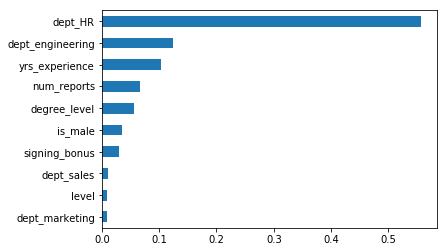

In [28]:
#Let's check variable importance
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('salary', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

It looks like the model is essentially just using dept and, to a lesser extent, num_reports, degree_level, and yrs_experience. All other variables are fairly irrelevant. 

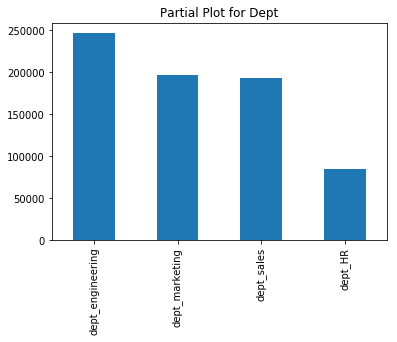

In [32]:
#Let's check partial dependence plots of the top 2 variables: dept and yrs_experience, as well as sex
from pdpbox import pdp, info_plots
  
#dept
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature=['dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Dept')
plt.show()

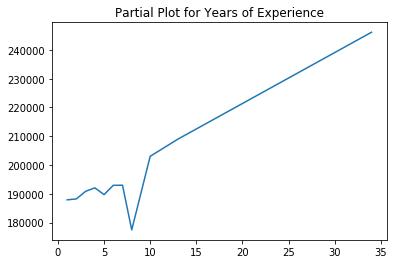

In [33]:
#yrs_experience
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='yrs_experience', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot for Years of Experience')
plt.show()

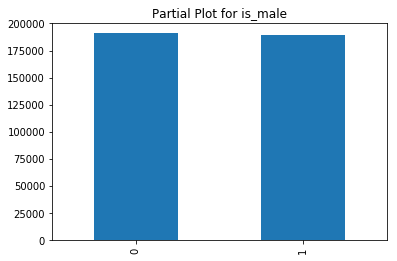

In [34]:
#is_male
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=train.drop('salary', axis=1),      
                          model_features=list(train.drop('salary', axis=1)), 
                          feature='is_male', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.sort_values(ascending=False).plot(kind='bar',title='Partial Plot for is_male')
plt.show()

Department is definitely the main driver of salary. The difference between HR and Engineering is very large.

Years of experience matters too, but less (note the smaller y range compared to dept). Most importantly, experience seems to matter more past a certain number. That is, salary will start going up after you become fairly senior. Within the first years, it doesn’t have much of an impact taken independently -> to make a lot of money you need to get to a very senior position.

Sex doesn’t appear to matter.



# Appendix 3 Data exploration

### Evaluation
By looking at the data. There are couple ways we can evaluate whether the segment of mployees are treated wores than others

- sign on bonous  
- salary  
- promotion after certain years  

The first two can get directly from the data. The third one need some data manumulpation. 

### Features
The dataset provides some very useful features:  
- degree  
- sex  
- department  
- yrs_experience 

We will start with Gender

## Gender

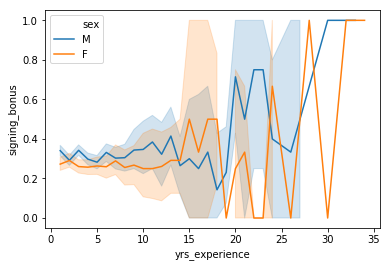

In [52]:
sns.lineplot(x="yrs_experience", y="signing_bonus", hue = 'sex', data=df)

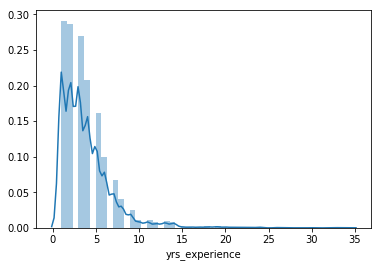

In [9]:
sns.distplot(df[df['yrs_experience'] > 15]['yrs_experience'])

In [53]:
f_total = len(df[df['sex'] == 'F'])
m_total = len(df[df['sex'] == 'M'])
total_em = 10000
f_w_sb = len(df[(df['signing_bonus'] == 1) & (df['sex'] == 'F')])
m_w_sb = len(df[(df['signing_bonus'] == 1) & (df['sex'] == 'M')])

print('This company has ' + str(f_total) + ' female employees, which account for ' 
      + str(f_total/total_em*100) + ' in total employees.')
print('This company has ' + str(m_total) + ' male employees, which account for ' 
      + str(m_total/total_em*100) + ' in total employees.')

This company has 3561 female employees, which account for 35.61 in total employees.
This company has 6439 male employees, which account for 64.39 in total employees.


In [43]:
print(f_w_sb/f_total)
print(m_w_sb/m_total)

0.39473684210526316
0.4307692307692308


The company has unblanced gender ratio. 65% are male and 35% are female.

In [54]:
df.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


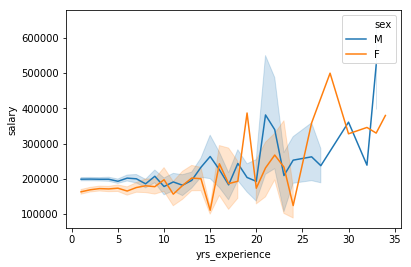

In [55]:
sns.lineplot(x="yrs_experience", y="salary", hue = 'sex', data=df)

In [76]:
df1 = df[df['yrs_experience'] > 15]
df2 = df[df['yrs_experience'] < 15]

In [77]:
df1.groupby(by='sex').mean()

,employee_id,signing_bonus,salary,yrs_experience,boss_id
sex,,,,,
F,98256.473684,0.394737,236552.631579,21.473684,83160.500000
M,101389.753846,0.430769,242384.615385,20.692308,98366.523077


In [78]:
df2.groupby(by='sex').mean()

,employee_id,signing_bonus,salary,yrs_experience,boss_id
sex,,,,,
F,100194.159330,0.270094,170644.703209,3.735586,101728.678216
M,99871.705688,0.316782,198409.176618,3.654620,104341.692598


In [79]:
print(171314.51839/198954.340736)
print(3.735586/3.654620)

0.8610745448239487
1.0221544237157352


In [74]:
236552.631579/242384.615385

0.9759391337740781

This tells us in people's early career (years of experence below 15). Women with longer average working experiences have 14% lower the average salary than man. The salary difference is smaller when the working experience is longer than 15 years with only 3% differnece between man and woman. 

We suggest to improve the women's salary especially they are in their junior stage of the career. By doing it, more women are likely to join the company. It also helps to balance the gender ratio.